### **RAG (Retrieval-Augmented Generation)**

Técnica avançada para ampliar o conhecimento de uma LLM com contexto adicional externo.

Composta por dois componentes principais:
- Recuperação de informação (Retrieval)
- Geração de respostas (Generation)

Instalação de bibliotecas

In [ ]:
!pip install -U -q langgraph langchain langchain-google-genai pypdf langchain_huggingface sentence_transformers faiss-cpu

*Imports* e *setup* de chaves de API.

- Google Gemini API Key: https://aistudio.google.com/app/apikey?hl=pt-br

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0) # instanciando o modelo Gemini

In [ ]:
from langchain import hub
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

loader = PyPDFLoader('pdf/cardapio.pdf') # carregando o texto do arquivo PDF (cardápio)
docs = loader.load() # gerando os documentos


In [4]:
# divisão do texto em chunks, necessário quando o(s) documento(s) é(são) muito grande(s)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2") # modelo de embeddings
vectorstore = FAISS.from_documents(all_splits, embedding=embeddings) # criando o vector store

/Users/lucasraniere/git/langgprah-intro-class/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
prompt = hub.pull("rlm/rag-prompt") # prompt utilizado para a RAG


# Definindo o estado da aplicação
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# função de recuperação de informação
def retrieve(state: State):
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}

# função de geração de resposta
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compilando grafo
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

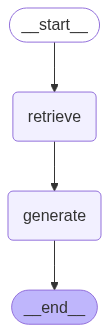

In [8]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [9]:
response = graph.invoke({"question": "Quais os ingredientes do X-BACON?"})
print(response["answer"])

O X-BACON contém alface, tomate, batata palha, milho, hambúrguer, presunto, muçarela e bacon.


In [10]:
response = graph.invoke({"question": "Quanto custa um FRANGO ESPECIAL?"})
print(response["answer"])

O FRANGO ESPECIAL custa R$ 22.


In [12]:
def multiply(a: int, b: int) -> int:
    """Multiplica a e b.

    Args:
        a (int): Primeiro número.
        b (int): Segundo número.
    """
    return a * b


def add(a: int, b: int) -> int:
    """Adiciona a e b.

    Args:
        a (int): Primeiro número.
        b (int): Segundo número.
    """
    return a + b

def sub(a: int, b: int) -> int:
    """Subtrai a e b.

    Args:
        a (int): Primeiro número.
        b (int): Segundo número.
    """
    return a - b


def divide(a: int, b: int) -> float:
    """Divide a e b.

    Args:
        a (int): Primeiro número.
        b (int): Segundo número.
    """
    return a / b


def rag(query: str):
    """Recebe a solicitação do cliente para ser pesquisada
    na base interna de RAG.

    Args:
        query (str): solicitação do cliente.
    """
    response = graph.invoke({"question": query})
    return response["answer"]


tools = [add, multiply, divide, sub, rag]
llm_with_tools = llm.bind_tools(tools)

In [13]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# Mensagem de sistema
sys_msg = SystemMessage(content='''
Você é um ajudante útil responsavel por responder questões sobre o cardápio de uma lanchonete.

Para tal, você terá acesso à ferramentas:

- Ferramenta de RAG: quando o usuário perguntar sobre coisas relacionadas ao cardápio, você acessar a base interna e verificar o pedido do cliente.
-- Seja específicos nas requisições, por exemplo: se o cliente perguntar o preço do produto X, solicite "produto X preço"
- Ferramentas de aritimética: caso a solicitação do cliente envolva aritmética referente aos preços dos lanches, você deve utilizar as ferramentas de aritmética para calcular.

Você tem acesso as seguintes ferramentas:
<tools>
-RAG
-multiply
-add
-sub
-divide
<\tools>

Caso a solicitação não tiver relação com a lachonete, reponda coridialmente que não pode ajudar e finalize o atendimento, indo para o END.

Caso o produto solicitado não estiver na base RAG, informe cordialmente ao cliente.
''')

# Nó
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

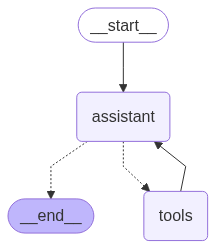

In [14]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Grafo
builder = StateGraph(MessagesState)

# Definição de nós
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Definição de arestas
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # if the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # if the latest message (result) from assistant is not a tool call -> tools_condition routes to end
    tools_condition,
    END
)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

# Visualização
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [15]:
messages = [HumanMessage(content="Quanto custa um X-FRANGO? mais um  X-BACON")]
messages = react_graph.invoke({"messages": messages})

In [16]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Quanto custa um X-FRANGO? mais um  X-BACON
================================== Ai Message ==================================
Tool Calls:
  rag (9731431a-81b3-4b74-b75b-25b782a94d31)
 Call ID: 9731431a-81b3-4b74-b75b-25b782a94d31
  Args:
    query: X-FRANGO preço
================================= Tool Message =================================
Name: rag

O preço do X-FRANGO é R$ 22. Este valor também se aplica a outras opções como X-BACON, X-BACON TURBO, X-FRANGO TURBO, Frango Especial e Frango Mega.
================================== Ai Message ==================================
Tool Calls:
  add (418ddf69-125f-4ce9-8430-07116f39604a)
 Call ID: 418ddf69-125f-4ce9-8430-07116f39604a
  Args:
    a: 22.0
    b: 22.0
================================= Tool Message =================================
Name: add

44
================================== Ai Message ==================================

O X-FRANGO custa R$ 2

In [17]:
messages = [HumanMessage(content="Quero comprar um FRANGO ESPECIAL e um refrigerante de 2 litros, quanto fica?")]
messages = react_graph.invoke({"messages": messages})

In [18]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Quero comprar um FRANGO ESPECIAL e um refrigerante de 2 litros, quanto fica?
================================== Ai Message ==================================
Tool Calls:
  rag (1c17cf92-2661-4799-98f2-932224f18b6c)
 Call ID: 1c17cf92-2661-4799-98f2-932224f18b6c
  Args:
    query: FRANGO ESPECIAL preço
  rag (247e77e0-cdfa-4f96-96cd-050ad490e1bf)
 Call ID: 247e77e0-cdfa-4f96-96cd-050ad490e1bf
  Args:
    query: refrigerante de 2 litros preço
================================= Tool Message =================================
Name: rag

O preço do FRANGO ESPECIAL é R$ 22.
================================= Tool Message =================================
Name: rag

O refrigerante de 2 litros custa R$ 9.
================================== Ai Message ==================================
Tool Calls:
  add (ef64dbbc-ffa3-44a9-9682-fc8f2e1a2c95)
 Call ID: ef64dbbc-ffa3-44a9-9682-fc8f2e1a2c95
  Args:
    a: 22.0
    b: 9.

In [19]:
messages = [HumanMessage(content="Quais os ingredientes do X-BACON?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Quais os ingredientes do X-BACON?
================================== Ai Message ==================================
Tool Calls:
  rag (bdb4395f-8ddc-4e14-9d3e-87656d939dfa)
 Call ID: bdb4395f-8ddc-4e14-9d3e-87656d939dfa
  Args:
    query: X-BACON ingredientes
================================= Tool Message =================================
Name: rag

The X-BACON includes lettuce, tomato, potato sticks, corn, hamburger, ham, mozzarella, and bacon.
================================== Ai Message ==================================

O X-BACON inclui alface, tomate, batata palha, milho, hambúrguer, presunto, mussarela e bacon.


In [20]:
messages = [HumanMessage(content="Quem descobriu as Américas?")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Quem descobriu as Américas?
================================== Ai Message ==================================

Não posso ajudar com essa pergunta. Minha função é responder apenas sobre o cardápio da lanchonete.
